### Librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Carga de datos

In [3]:
def carga_de_datos(nombre):
    data = pd.read_csv('./Data/'+nombre+'.csv')
    data['clase'] = nombre
    return data
data_list= ['bajar_monte','subir_monte','bici','coche']
# un df por cada csv
df_list = [carga_de_datos(data) for data in data_list]
df_bajar_monte = df_list[0]
df_subir_monte = df_list[1]
df_bici = df_list[2]
df_coche = df_list[3]

#### Visualizacion en el dominio temporal

In [4]:
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.grid()
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# DOMINIO TEMPORAL

KeyError: 'Frecuencia (Hz)'

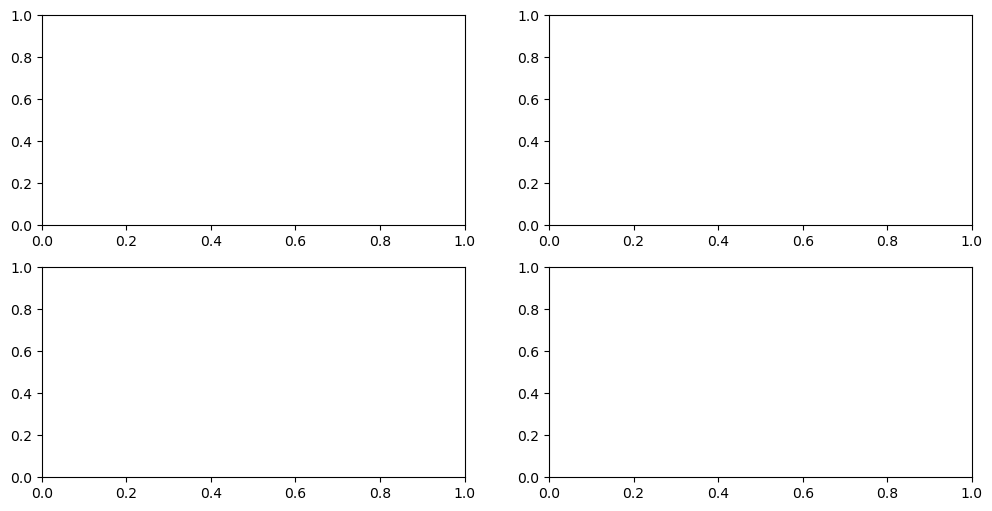

In [6]:
import matplotlib.pyplot as plt

def plot_acceleration_freq(df_list, titles):
    num_plots = len(df_list)
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    for i in range(num_plots):
        row = i // 2
        col = i % 2
        axs[row, col].plot(df_list[i]['Frecuencia (Hz)'], df_list[i]['Amplitud (m/s^2)'])
        axs[row, col].set_title(titles[i])
        axs[row, col].set_xlabel('Frecuencia [Hz]')
        axs[row, col].set_ylabel('Amplitud [$m/s^2$]')
    plt.tight_layout()

# Uso de la función
df_a = [df_bajar_monte, df_subir_monte, df_bici, df_coche]
titles = ['Bajar monte', 'Subir monte', 'Bici', 'Coche']

plot_acceleration_freq(df_a, titles)
plt.show()


# DOMINIO FRECUENCIAL

In [ ]:
df_ejemplo= df_bajar_monte

In [74]:
T=df_ejemplo['Time (s)'].diff().mean()
fs=1/T
print('Fs= ',fs)

Fs=  100.30355164194997


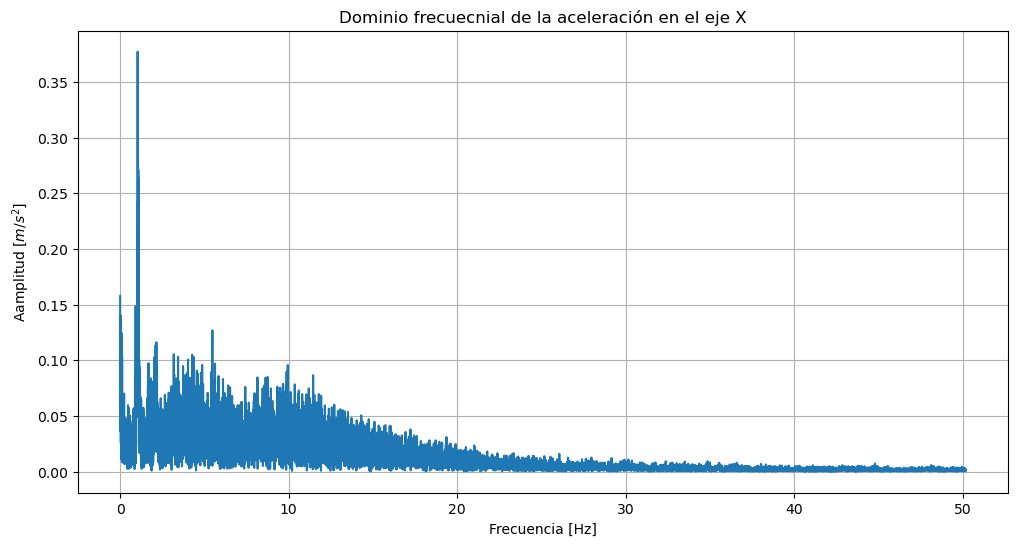

In [75]:
rfft_output = np.fft.rfft(df_ejemplo['Linear Acceleration x (m/s^2)'])
rfft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(rfft_output) for i in rfft_output]
rfreqs = [(i*1.0/len(df_ejemplo))*fs for i in range(len(df_ejemplo)//2+1)]

setup_graph('Dominio frecuecnial de la aceleración en el eje X', 'Frecuencia [Hz]', 'Aamplitud [$m/s^2$]', fig_size=(12,6))
plt.plot(rfreqs, rfft_mag)

In [76]:
print('Frecuencia dominante: ',rfreqs[np.argmax(rfft_mag)])
print('PSD: ',np.sum(rfft_mag))
print('Skewness:',df_ejemplo['Linear Acceleration x (m/s^2)'].skew())
print('Kurtosis:',df_ejemplo['Linear Acceleration x (m/s^2)'].kurtosis())

Frecuencia dominante:  1.037430321700493
PSD:  169.93820201841066
Skewness: 0.3689826783103134
Kurtosis: 7.19603338253021


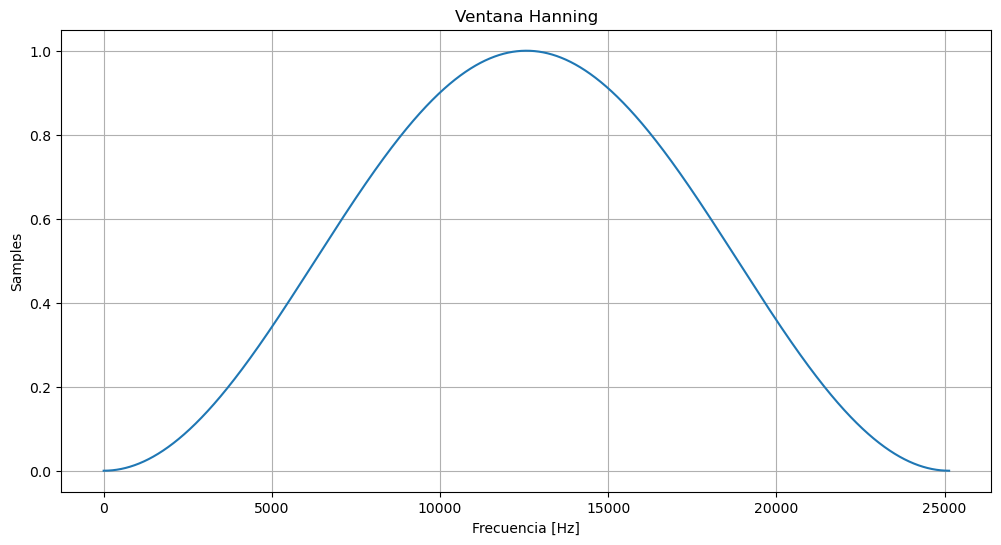

In [77]:
from scipy.signal import get_window
window=get_window("hann",len(df_ejemplo),fftbins=True)
setup_graph('Ventana Hanning', 'Frecuencia [Hz]', 'Samples', fig_size=(12,6))
plt.plot(window)

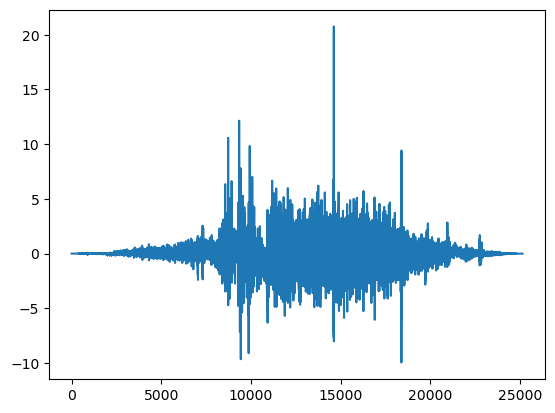

In [78]:
plt.plot(df_ejemplo['Linear Acceleration x (m/s^2)']*window)

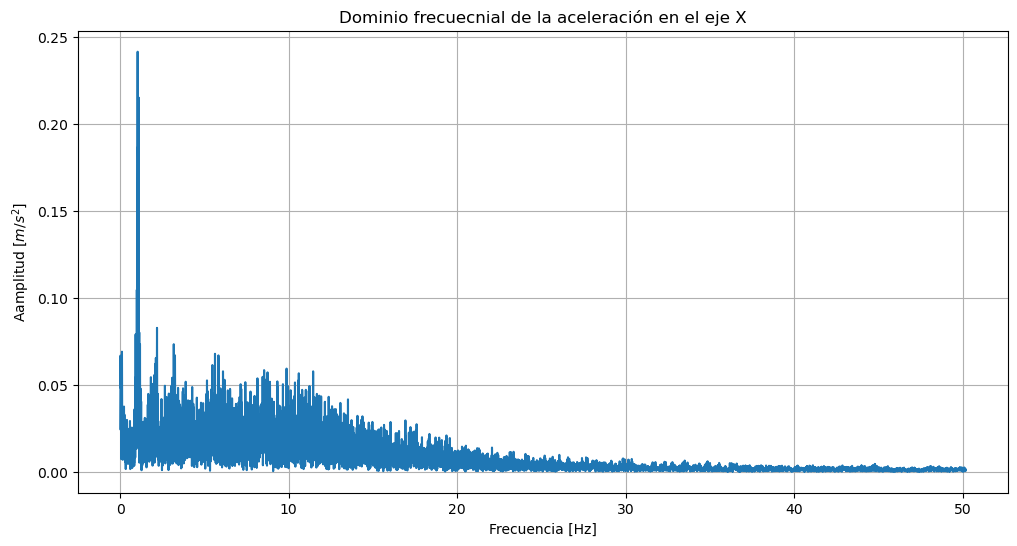

In [79]:
rfft_output = np.fft.rfft(df_ejemplo['Linear Acceleration x (m/s^2)']*window)
rfft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(rfft_output) for i in rfft_output]
rfreqs = [(i*1.0/len(df_ejemplo))*fs for i in range(len(df_ejemplo)//2+1)]

setup_graph('Dominio frecuecnial de la aceleración en el eje X', 'Frecuencia [Hz]', 'Aamplitud [$m/s^2$]', fig_size=(12,6))
plt.plot(rfreqs, rfft_mag)

In [80]:
print('Frecuencia dominante: ',rfreqs[np.argmax(rfft_mag)])
print('PSD: ',np.sum(rfft_mag))

Frecuencia dominante:  1.037430321700493
PSD:  110.76309324887653


In [81]:
def Myfft(Fs, X):
    from scipy.signal import get_window
    window = get_window("hann", len(X), fftbins=True)
    X=X*window
    ##
    fft_out = np.fft.rfft(X)
    fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
    num_samples = len(X)
    rfreqs = [(i*1.0/num_samples)*Fs for i in range(num_samples//2+1)]
    return fft_mag, rfreqs

In [82]:
#Funcion para obtener
def freq_features(raw_df, window_size=1000,step_size=500):
    data=[]
    for i in range(0, len(raw_df) - window_size + 1, step_size):

        window_data_X = raw_df.iloc[i:i+window_size,1] #X_axis
        window_data_Y = raw_df.iloc[i:i+window_size,2] #Y_axis
        window_data_Z = raw_df.iloc[i:i+window_size,3] #Z_axis

        fft_mag_X, fft_freq=Myfft(fs,window_data_X)
        fft_mag_Y, _ =Myfft(fs,window_data_Y)
        fft_mag_Z, _ =Myfft(fs,window_data_Z)
        data.append([fft_freq[np.argmax(fft_mag_X)],np.sum(fft_mag_X),fft_freq[np.argmax(fft_mag_Y)],np.sum(fft_mag_Y),fft_freq[np.argmax(fft_mag_Z)],np.sum(fft_mag_Z)])

    freq_features = pd.DataFrame(data,columns=['DF X', 'PSD X','DF Y', 'PSD Y','DF Z', 'PSD Z'])
    return freq_features

In [83]:
subir_monte=freq_features(df_subir_monte)
bajar_monte=freq_features(df_bajar_monte)
bici=freq_features(df_bici)
coche=freq_features(df_coche)

In [84]:
df_frecuencial=pd.concat([subir_monte, bajar_monte,bici,coche])
df_frecuencial.head()

,DF X,PSD X,DF Y,PSD Y,DF Z,PSD Z
0,0.501518,19.015551,0.601821,15.583148,0.501518,23.675710
1,0.501518,19.511018,0.501518,15.326879,0.000000,13.028594
2,0.501518,20.601642,0.501518,15.315404,0.000000,13.420502
3,0.501518,20.959415,0.501518,16.260063,0.000000,12.203606
4,0.501518,19.254408,0.501518,14.718024,0.000000,10.437852


In [85]:
# creame un ANN para clasificar los datos
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

X = df_frecuencial.iloc[:,0:6].values
y = df_frecuencial.iloc[:,6].values

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = keras.Sequential([
    keras.layers.Dense(6, input_shape=(6,), activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1000)
# devueveme el mejor modelo
model.evaluate(X_test, y_test)


IndexError: single positional indexer is out-of-bounds